# Lab 2 - Optical Tweezers Analysis

Elliot Wadge & Hamish Johnson\
SFU PHYS 332W, Spring 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from tool import local_max, noise, circle, outliers, gaussian, make_histogram_projection, extract_data, get_k_equipartition, gaussian_analysis
import numpy.random as rand
from scipy.optimize import curve_fit
from scipy import integrate
import scipy.constants as cnst
from glob import glob
from IPython.display import display
from matplotlib.gridspec import GridSpec

## Generate nm:px Conversion Ratio

[32.1598 32.2925 32.5363 ... 32.8029 32.8942 32.8164]

pixel sep = 236.8 +/- 0.98 [pixels]
nm/px = 42.23 +/- 0.175 [nm/px]
px/um = 23.68 +/- 0.098 [px/um]


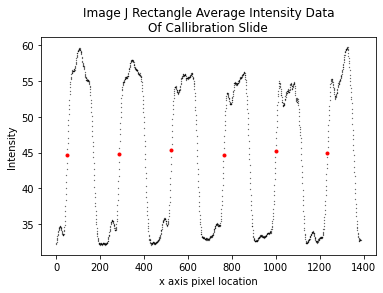

In [2]:
data = np.genfromtxt("/work/data/Calibration2.txt",delimiter='\t', skip_header = 1).T
x_dat = data[0]
y_dat = data[1]
print(y_dat)

maxes, idx = local_max(-np.abs(y_dat-45),N=90)

plt.plot(x_dat,y_dat,"k.",markersize=0.5)
plt.plot(x_dat[idx][::2],y_dat[idx][::2],"r.")
pixel_seperation = np.mean(np.diff(x_dat[idx][::2])) # separation in px
uncert_px = np.std(np.diff(x_dat[idx][::2]))
um_per_px = 10/pixel_seperation
um_per_px_err = (uncert_px/pixel_seperation)*um_per_px
plt.xlabel("x axis pixel location")
plt.ylabel("Intensity")
plt.title("Image J Rectangle Average Intensity Data\nOf Callibration Slide")
plt.savefig("Notes/callibration_pixelToDistance.pdf",dpi=300)

dec = 3
print("\npixel sep =",np.around(pixel_seperation,dec),"+/-",np.around(uncert_px,dec),"[pixels]")

print("nm/px =",np.around(um_per_px*1000,dec),"+/-",np.around(um_per_px_err*1000,dec),"[nm/px]")

print("px/um =",np.around(um_per_px**(-1),dec),"+/-",np.around((um_per_px_err/um_per_px)*um_per_px**(-1),dec),"[px/um]")


## Find Average Lab Temp

In [3]:
tempArray = np.array([22,20,20,21,19])
# C, via Meterman 33XR with thermocouple - We are assuming that
# the errors in this value wont matter very much in further
# analysis so the measurment device prescision is not of great
# importance for our analysis (negligible)

tempArray = tempArray + 273.15 # to kelvin

aveTemp = np.mean(tempArray)
tempErr = np.std(tempArray)/np.sqrt(len(tempArray))

print(f"Temperature = {aveTemp:.1f} +/- {tempErr:.1f} [K]")

T = aveTemp

Temperature = 293.6 +/- 0.5 [K]


## Import Sample D Raw Data
#### Further down we fit gaussian PDFs to histograms of x and y displacement after this preliminary exploration.

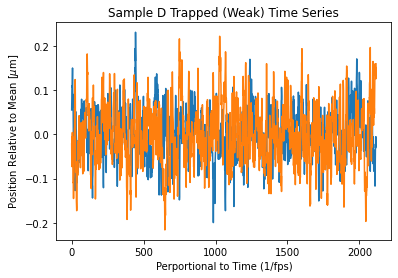

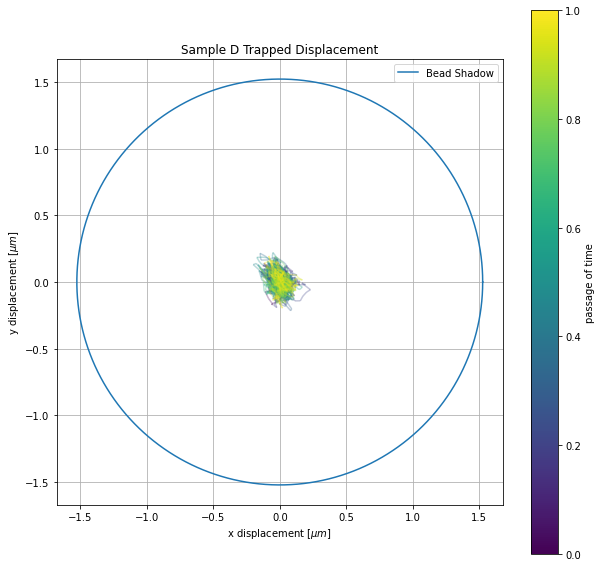

In [4]:
filename = "/work/data/SampleD_trapped2.txt"
data = extract_data(filename, skip_footer = 1200)
x = data.x
y = data.y
rad_dat = data.rad_dat

plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.title("Sample D Trapped (Weak) Time Series")
#fig.savefig('Notes/weakTrappedBead_timeSeries.pdf',dpi = 300)
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y,label = "Bead Shadow")
ax.legend()
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

x_trapped = x
y_trapped = y

#fig.savefig('Notes/weakTraped_scatter.pdf',dpi = 300)

[[ 1.         -0.94813111]
 [-0.94813111  1.        ]]
[[ 1.        -0.4263383]
 [-0.4263383  1.       ]]
with drift removed std x = 0.0388264215111741
with drift removed std y = 0.04754312345812869


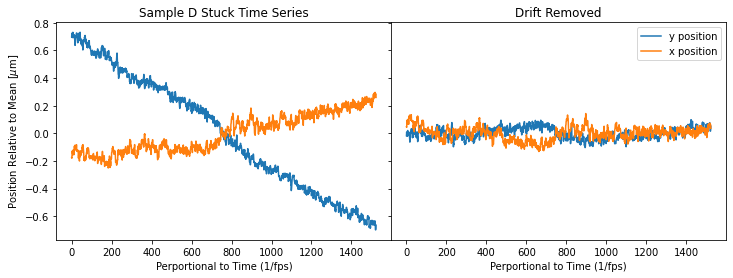

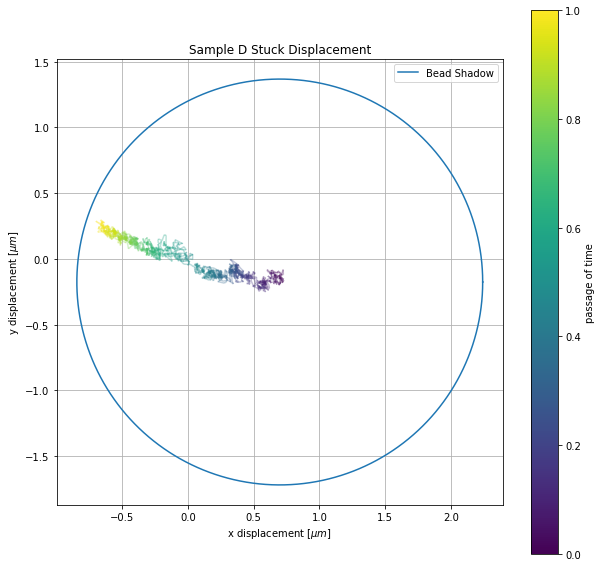

In [5]:
filename = "/work/data/SampleD_stuckBead4.txt"
data = extract_data(filename)
x = data.x_dat - np.mean(data.x_dat)
y = data.y_dat - np.mean(data.y_dat)
rad_dat = data.rad_dat

print(np.corrcoef(x,y))

fitx = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),x, deg = 1)
fity = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),y, deg = 1)
x_no_drift = x - fitx(np.arange(0,len(x),1))
y_no_drift = y - fity(np.arange(0,len(x),1))

print(np.corrcoef(x_no_drift,y_no_drift))

print(f"with drift removed std x = {np.std(x_no_drift)}")
print(f"with drift removed std y = {np.std(y_no_drift)}")

fig = plt.figure(figsize = (12,4))
gs = fig.add_gridspec(1,2, hspace=0,wspace = 0)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)

ax1.plot(x,label=r"x position")
ax1.plot(y,label=r"y position")

ax1.set(title = "Sample D Stuck Time Series", xlabel = "Perportional to Time (1/fps)", ylabel = "Position Relative to Mean [$\mu$m]");

ax2.plot(x_no_drift, label = 'y position')
ax2.plot(y_no_drift, label = 'x position')
ax2.set(title = "Drift Removed", xlabel = "Perportional to Time (1/fps)");
plt.legend()
plt.savefig('Notes/stuck_bead_timeSeries.pdf',dpi = 300)
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]

fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y,label = "Bead Shadow")
ax.legend()
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Stuck Displacement",
        aspect = 'equal');

fig.savefig('Notes/stuck_bead_scatter.pdf',dpi = 300)

142 outliers found
[[ 1.         -0.58468484]
 [-0.58468484  1.        ]]


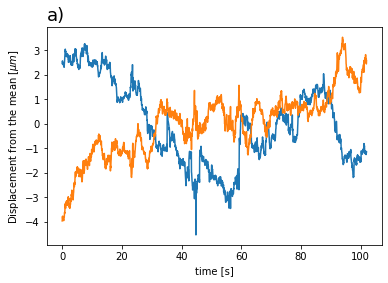

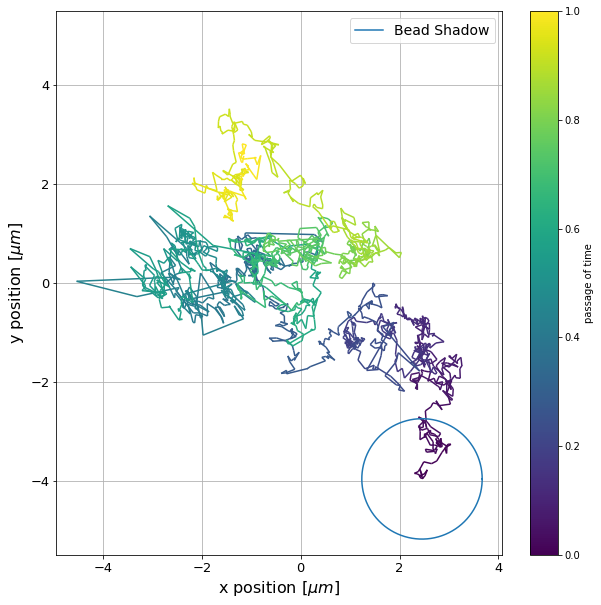

In [90]:
filename = "/work/data/SampleD_loneRandomWalk.txt"
data = extract_data(filename)
x = data.x_dat - np.mean(data.x_dat)
y = data.y_dat - np.mean(data.y_dat)
rad_dat = data.rad_dat

fig = plt.figure(figsize = (6,4))
plt.plot(np.linspace(0,len(x)//20,len(x)),x,label=r"x position")
plt.plot(np.linspace(0,len(y)//20, len(y)),y,label=r"y position")
plt.xlabel("time [s]")
plt.ylabel("Displacement from the mean [$\mu m$]")
plt.text(-5,4.2, 'a)', fontsize = 18)
print(np.corrcoef(x,y))


fig.savefig('Notes/free_walk_timeSeries.pdf',dpi = 300)
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis')
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y,label = "Bead Shadow")
ax.legend(fontsize = 14)
ax.set(aspect = 'equal', ylim = (-5.5,5.5));


ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_xlabel('x position [$\mu m$]', fontsize = 16)
ax.set_ylabel('y position [$\mu m$]', fontsize = 16)
fig.savefig('Notes/free_walk_scatter.pdf',dpi = 300)

# Autocorrelation Analysis

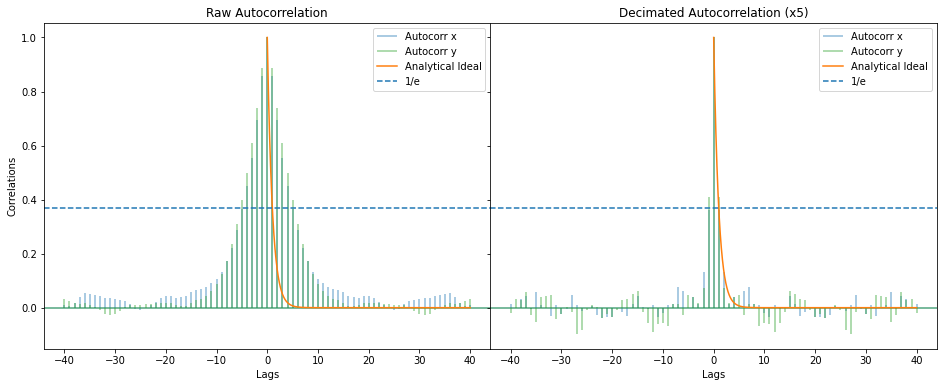

In [7]:
fig = plt.figure(figsize = (16,6))
gs = fig.add_gridspec(1,2, hspace=0,wspace = 0)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
#fig.suptitle('Autocorrelation for Decimation')

# Plot experimental autocorrelation
# I dont know if these are the values we want tho
k = 1
gamma = 1
tau_0 = k/gamma
deltaT = 0.01
D = 1 #= kB T / gamma

x = x_trapped
y = y_trapped

maxLagVal = 40
model = np.linspace(1e-5,maxLagVal,10000)

ax1.acorr(x, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax1.acorr(y, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax1.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax1.axhline(1/np.e,linestyle = "dashed",label = r"1/e")
ax1.set(title = "Raw Autocorrelation", xlabel = 'Lags', ylabel = "Correlations")
ax1.legend()


# Decimate data
interval = 5
x_dec = x[::interval]
y_dec = y[::interval]
#lol waht happened?
# idk did it shut down?

# Plot decimated autocorrelation
ax2.acorr(x_dec, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax2.acorr(y_dec, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax2.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax2.axhline(1/np.e,linestyle = "dashed",label = r"1/e")
ax2.legend()
ax2.set(title = f"Decimated Autocorrelation (x{interval})",xlabel = "Lags")
plt.savefig("Notes/autocorrelationDecimationPlot.pdf",dpi = 300)
plt.show()

## Correlation between x and y

In [8]:
mean_x = np.mean(x)
mean_y = np.mean(y)

r = np.sum((x-mean_x)*(y-mean_y))/(np.sqrt(np.sum((x - mean_x)**2))*np.sqrt(np.sum((y - mean_y)**2)))

print(f"r = {r}\nThere is in fact some negative correlation between x and y, but not much. We will look into\nthis deeper in the reproducability section where we can see if this is random, systematic, or\nsystematic with each bead but random between beads.")

r = -0.3385514290403072
There is in fact some negative correlation between x and y, but not much. We will look into
this deeper in the reproducability section where we can see if this is random, systematic, or
systematic with each bead but random between beads.


# Equipartition Method - Determining k

In [9]:
# Eq 2) U = kx^2/2
# Eq 28) 1/2 k var(disp_from_mean) = 1/d k_b T
# therefore: k = k_b T / var(disp_from_mean)

k_b = cnst.Boltzmann # m^2 kg s-2 K-1
var_x = np.var(x_dec/(10**6))
var_y = np.var(y_dec/(10**6))

k_x = k_b*T/(var_x)
k_y = k_b*T/(var_y)

print("Spring Constant in x =",k_x,"[N/m]")
print("Spring Constant in y =",k_y,"[N/m]")

print("\nWe have made a method to quickly do this in further analysis,\nhowever the Gaussian Fit method is more robust to fluctuations\nand allows us to popagate errors so we will mostly use that in\nfurther analysis.")

Spring Constant in x = 1.4683053451859432e-06 [N/m]
Spring Constant in y = 8.364447027021885e-07 [N/m]

We have made a method to quickly do this in further analysis,
however the Gaussian Fit method is more robust to fluctuations
and allows us to popagate errors so we will mostly use that in
further analysis.


# Gaussian fit method

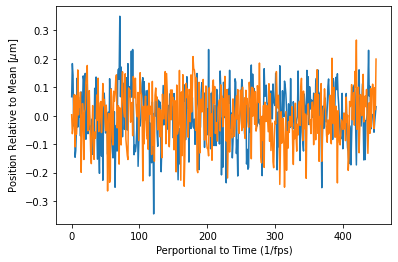

Via Gaussian Fit Method
k_x = 0.47005881220948526
k_y = 0.5194326707666144
Via equipartition
k_x = 0.4663517870740569
k_y = 0.47906744942805907


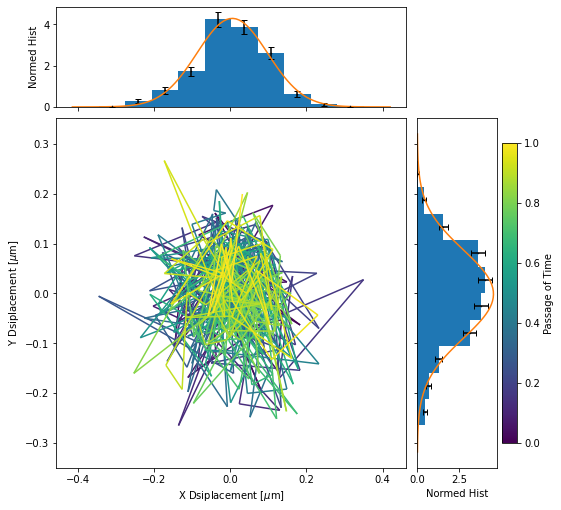

In [10]:
plt.close()
filename = "/work/data/SampleD_trapped1.txt"
ret = extract_data(filename)
plt.plot(ret.x_dec,label=r"x position")
plt.plot(ret.y_dec,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")

plt.savefig('Notes/weakTrappedBead_timeSeries.pdf',dpi = 300)
plt.show()

analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = False,temp = T)
print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")

k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

plt.savefig("Notes/Example_scatterWithgaussianFit_weak.pdf",dpi = 300)
plt.show()

1.5080071928587204 0.015049971541478054
[[ 1.         -0.31953795]
 [-0.31953795  1.        ]]


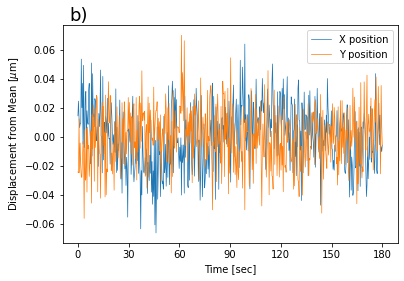

for y:
mean = -0.0004847493152043991
sigma = 0.02002470965142813
variance = 0.0004009889966239988
k = 10.107247763958815 [pN/um]
Fit Statistics
 ChiSq = 7.411469881097723 +/- 4.0
 nu = 8
 Reduced Chi = 0.9264337351372154
for x:
mean = 0.0003511053978201353
sigma = 0.02122162423362626
variance = 0.00045035733511323325
k = 8.999287506843832 [pN/um]
Fit Statistics
 ChiSq = 4.785515432244825 +/- 4.0
 nu = 8
 Reduced Chi = 0.5981894290306031


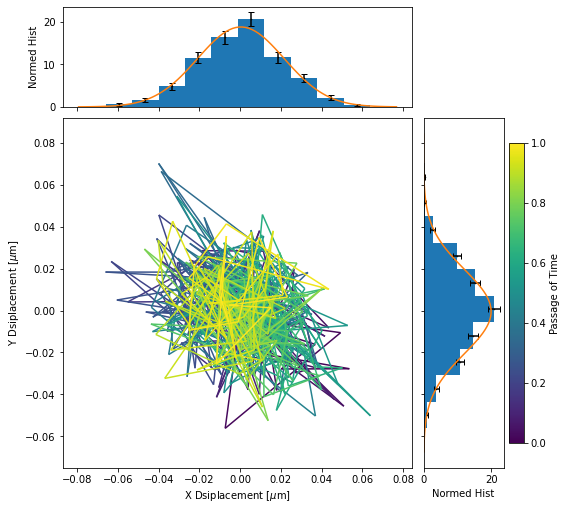

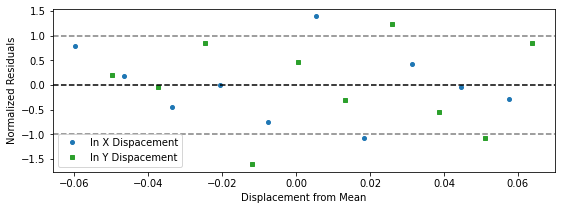

Via Gaussian Fit Method
k_x = 8.999287506843832
k_y = 10.107247763958815
Via equipartition
k_x = 9.331177697317496
k_y = 10.51550300803164


In [85]:
filename = '/work/data/reproducibility/StrongRep1.txt'
ret = extract_data(filename)

print(np.mean(ret.rad_dat),np.std(ret.rad_dat))
t = np.linspace(0,180,len(ret.x_dec))

plt.plot(t,ret.x_dec,label=r"X position",linewidth = 0.7)
plt.plot(t,ret.y_dec,label=r"Y position",linewidth = 0.7)
plt.xticks([0,30,60,90,120,150,180])
plt.xlabel("Time [sec]")
plt.ylabel("Displacement from Mean [$\mu$m]")
plt.text(-5,0.08,'b)', fontsize = 18)
plt.legend()
plt.savefig('Notes/strongTrappedBead_timeSeries.pdf',dpi = 300)

print(np.corrcoef(ret.x_dec,ret.y_dec))

plt.show()

analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = True,temp = T,axTitle = "Strong Trap Displacement with Fitted Histograms")
plt.savefig("scatterWithgaussianFit_strong.pdf",dpi = 300)
plt.show()

fig = plt.figure(figsize = (9,3))
normRes_x = analysis2.res_x/analysis2.sigma_x
normRes_y = analysis2.res_y/analysis2.sigma_y
plt.plot(analysis2.bins_x, normRes_x,".",label = "In X Dispacement",color = "C0",markersize = 8)
plt.plot(analysis2.bins_y, normRes_y,"s",label = "In Y Dispacement" , color = "C2",markersize = 4)
plt.axhline(0,color = "Black",linestyle = "--")
plt.axhline(-1, color = "Grey",linestyle = "--")
plt.axhline(1, color = "Grey",linestyle = "--")
plt.legend()
plt.xlabel("Displacement from Mean")
plt.ylabel("Normalized Residuals")
plt.savefig("scatterWithgaussianFit_strong_residuals.pdf",dpi = 300)
plt.show()

print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")

k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

# Reproducability Analysis

Strong 1 Diameter = 3.016 +/- 0.030 [um]	Corr = -0.320	k_x = 9.735 +/- 0.595 [pN/um] 	 k_y = 10.512 +/- 0.660 [pN/um]
Strong 2 Diameter = 3.129 +/- 0.025 [um]	Corr = -0.334	k_x = 11.377 +/- 0.706 [pN/um] 	 k_y = 12.023 +/- 0.796 [pN/um]
Strong 3 Diameter = 3.040 +/- 0.031 [um]	Corr = -0.321	k_x = 10.941 +/- 0.709 [pN/um] 	 k_y = 10.654 +/- 0.747 [pN/um]
Strong 4 Diameter = 2.949 +/- 0.019 [um]	Corr = -0.237	k_x = 12.589 +/- 0.788 [pN/um] 	 k_y = 10.028 +/- 0.692 [pN/um]
Strong 5 Diameter = 3.105 +/- 0.022 [um]	Corr = -0.383	k_x = 6.669 +/- 0.461 [pN/um] 	 k_y = 10.353 +/- 0.668 [pN/um]
Average Radius = 3.044 +/- 0.072 [um]	Average k_x = 9.862 +/- 2.453 [pN/um]	Average k_y = 10.675 +/- 0.741 [pN/um]

Average correlation (xy) = -0.319 +/- 0.047

There is noticeable variation in bead size.
There is systematic negative correlation between y and x positions.


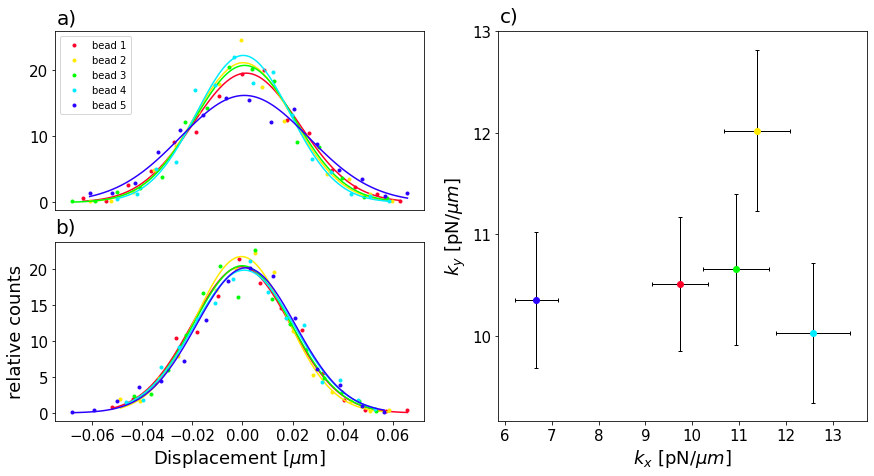

In [112]:
filenames = np.sort(np.array(glob(('data/reproducibility/Strong*'))))

#fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (10,12), gridspec_kw={'height_ratios': [1, 1, 1.3]})
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(1,2,2)


fig.tight_layout()
colors = cm.get_cmap('gist_rainbow')
print(colors)
radiusArray = []
radiusArray_err = []
correlationArray = []
kx_array = []
ky_array = []
kx_err_array = []
ky_err_array = []
for i,filename in enumerate(filenames):
    data = extract_data(filename)
    analysis = gaussian_analysis(data.x_dec, data.y_dec, nbins=15,temp = T)
    
    color = colors(i/len(filenames))
    
    dx = np.linspace(min(analysis.bins_x), max(analysis.bins_x), 100)
    ax1.plot(analysis.bins_x, analysis.hist_x, '.', color= color, label = 'bead ' + str(i + 1))
    ax1.plot(dx, gaussian(dx,*analysis.pOpt_x), color= color)
    

    dx = np.linspace(min(analysis.bins_y), max(analysis.bins_y), 100)
    ax2.plot(analysis.bins_y, analysis.hist_y, '.',color= color,label = filename.split('/')[-1].split('.')[0])
    ax2.plot(dx, gaussian(dx,*analysis.pOpt_y),color= color)
    ax3.scatter(analysis.k_x, analysis.k_y,color= color)

    std_sigma = np.sqrt(np.diag(analysis.pCov_x))[1]
    sigma = analysis.pOpt_x[1]
    kx_error = 2*k_b*10**18*T/sigma**3*std_sigma

    std_sigma = np.sqrt(np.diag(analysis.pCov_y))[1]
    sigma = analysis.pOpt_y[1]
    ky_error = 2*k_b*10**18*T/sigma**3*std_sigma
    
    ax3.errorbar(analysis.k_x, analysis.k_y, yerr = ky_error, xerr = kx_error, fmt = 'k',linewidth = 1, capsize=2, zorder = 0)
    
    # Calculate xy correlation
    corelationCoef = np.corrcoef(data.x_dec,data.y_dec)[1][0]

    print(f"Strong {i+1} Diameter = {np.mean(data.rad_dat)*2:.3f} +/- {np.std(data.rad_dat)*2:.3f} [um]\tCorr = {corelationCoef:.3f}\tk_x = {analysis.k_x:.3f} +/- {kx_error:.3f} [pN/um] \t k_y = {analysis.k_y:.3f} +/- {ky_error:.3f} [pN/um]")
    radiusArray.append(np.mean(data.rad_dat)*2)
    radiusArray_err.append(np.std(data.rad_dat)*2)
    correlationArray.append(corelationCoef)
    kx_array.append(analysis.k_x)
    ky_array.append(analysis.k_y)
    kx_err_array.append(kx_error)
    ky_err_array.append(ky_error)

radiusArray_err = np.array(radiusArray_err)
radiusArray_weights = 1/radiusArray_err
radiusArray = np.array(radiusArray)
correlationArray = np.array(correlationArray)
kx_array = np.array(kx_array)
ky_array = np.array(ky_array)
kx_err_array = np.array(kx_err_array)
ky_err_array = np.array(ky_err_array)

averageRadius = np.average(radiusArray,weights = radiusArray_weights)
averageRadius_err = np.sqrt(np.cov(radiusArray, aweights=1/radiusArray))

average_kx = np.average(kx_array,weights = 1/kx_err_array)
average_kx_err = np.sqrt(np.cov(kx_array, aweights=1/kx_array))

average_ky = np.average(ky_array,weights = 1/ky_err_array)
average_ky_err = np.sqrt(np.cov(ky_array, aweights=1/ky_array))

print(f"Average Radius = {averageRadius:.3f} +/- {averageRadius_err:.3f} [um]\tAverage k_x = {average_kx:.3f} +/- {average_kx_err:.3f} [pN/um]\tAverage k_y = {average_ky:.3f} +/- {average_ky_err:.3f} [pN/um]")

print(f"\nAverage correlation (xy) = {np.mean(correlationArray):.3f} +/- {np.std(correlationArray):.3f}")

print("\nThere is noticeable variation in bead size.\nThere is systematic negative correlation between y and x positions.")



ax1.set_xticks([], [])
ax2.set_xlabel('Displacement [$\mu$m]', fontsize = 18)
ax2.set_ylabel('relative counts', fontsize = 18)
ax3.set(yticks=(10,11,12,13))
ax3.set_xlabel('$k_x$ [pN/$\mu m$]', fontsize = 18)
ax3.set_ylabel('$k_y$ [pN/$\mu m$]', fontsize = 18)
ax1.text(-0.072, 27, 'a)', fontsize = 20)
ax2.text(-0.075, 25, 'b)', fontsize = 20)
ax3.text(5.9, 13.1, 'c)', fontsize = 20)
plt.subplots_adjust(wspace = 0.2)
ax1.legend(loc = 'upper left');

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)

fig.savefig('Notes/reproducibility.pdf', bbox_inches = 'tight',dpi = 300)


in x
Fit Statistics
 ChiSq = 11.010415545160104 +/- 5.0990195135927845
 nu = 13
 Reduced Chi = 0.8469550419353926

in y
Fit Statistics
 ChiSq = 13.396922831449274 +/- 5.0990195135927845
 nu = 13
 Reduced Chi = 1.030532525496098


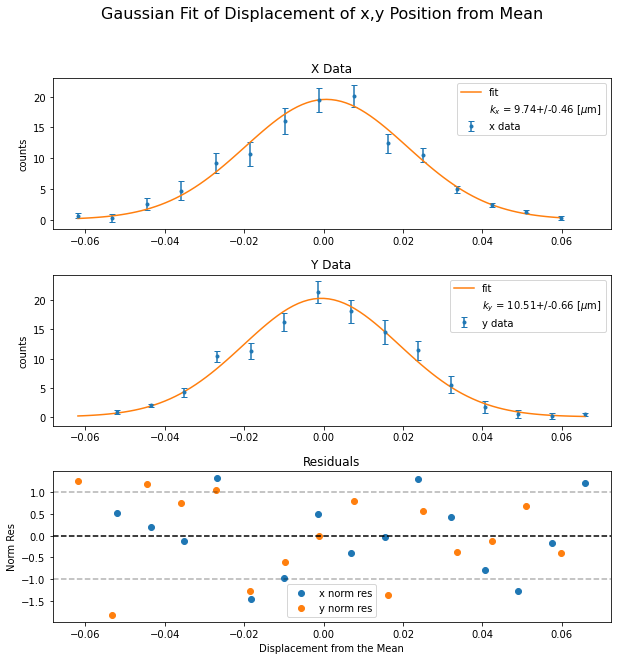

In [13]:
filename = 'data/reproducibility/StrongRep1.txt'
data = extract_data(filename)
analysis = gaussian_analysis(data.x_dec, data.y_dec,temp = T, nbins = 15)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (10,10))

dx = np.linspace(min(analysis.bins_x), max(analysis.bins_x), 100)
ax1.errorbar(analysis.bins_x, analysis.hist_x, fmt = '.', yerr = analysis.sigma_y, capsize = 3, label = 'x data')
ax1.plot(dx, gaussian(dx,*analysis.pOpt_x), label = 'fit')

# Add fitted k value to legend
std_sigma = np.sqrt(np.diag(analysis.pCov_x))[1]
sigma = analysis.pOpt_x[1]
ky_error = 2*k_b*10**18*T/sigma**3*std_sigma
ax1.plot(0,0,label = r"$k_x$ = " + str(np.around(analysis.k_x,2))+"+/-"+str(np.around(kx_error,2))+r" [$\mu$m]",alpha = 0)


ax1.set(ylabel = 'counts',title = "X Data")
ax1.legend()

dx = np.linspace(min(analysis.bins_x), max(analysis.bins_y), 100)
ax2.errorbar(analysis.bins_y, analysis.hist_y, fmt = '.', yerr= analysis.sigma_x, capsize=3, label = 'y data')
ax2.plot(dx, gaussian(dx,*analysis.pOpt_y), label = 'fit')

# Add fitted k value to legend
std_sigma = np.sqrt(np.diag(analysis.pCov_y))[1]
sigma = analysis.pOpt_y[1]
ky_error = 2*k_b*10**18*T/sigma**3*std_sigma
ax2.plot(0,0,label = r"$k_y$ = " + str(np.around(analysis.k_y,2))+"+/-"+str(np.around(ky_error,2))+r" [$\mu$m]",alpha = 0)

ax2.set(ylabel = 'counts',title = "Y Data")
ax2.legend()

norm_res1 = (analysis.hist_y - gaussian(analysis.bins_y,*analysis.pOpt_y))/analysis.sigma_y
norm_res2 = (analysis.hist_x - gaussian(analysis.bins_x,*analysis.pOpt_x))/analysis.sigma_x

ax3.scatter(analysis.bins_y,norm_res1, label = 'x norm res')
ax3.scatter(analysis.bins_x,norm_res2, label = 'y norm res')
ax3.axhline(y = 0, color = 'k', linestyle = '--')
ax3.axhline(y = 1, color = 'k', linestyle = '--', alpha = 0.3)
ax3.axhline(y = -1, color = 'k', linestyle = '--', alpha = 0.3)
ax3.set(xlabel = 'Displacement from the Mean',ylabel = "Norm Res", title = 'Residuals')
ax3.legend()


# Calculate Chi squared statistics
N = len(analysis.bins_x)
chiSq = np.sum(norm_res1**2)
nu = N  - 2 # points minus #fit parameters
chiSigma = np.sqrt(2*nu)
print("\nin x")
print("Fit Statistics\n ChiSq =",chiSq,"+/-",chiSigma)
print(" nu =",nu)
print(" Reduced Chi =",chiSq/nu)

# Calculate Chi squared statistics
N = len(analysis.bins_y)
chiSq = np.sum(norm_res2**2)
nu = N  - 2 # points minus #fit parameters
chiSigma = np.sqrt(2*nu)
print("\nin y")
print("Fit Statistics\n ChiSq =",chiSq,"+/-",chiSigma)
print(" nu =",nu)
print(" Reduced Chi =",chiSq/nu)

ax3.sharex(ax1)
ax2.sharex(ax1)

plt.subplots_adjust(hspace = 0.3)
fig.suptitle('Gaussian Fit of Displacement of x,y Position from Mean', fontsize=16)

fig.savefig('Notes/gaussian_fit_and_residuals.pdf', bbox_inches = 'tight',dpi = 300)


<function glob at 0x7f407dd49d40>
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.


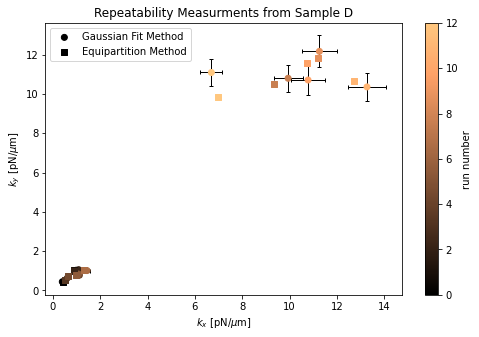

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.


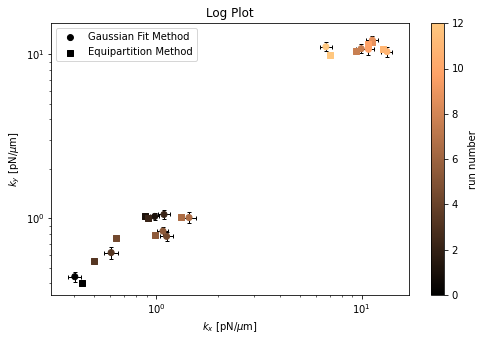

In [14]:
filenames1 = np.sort(glob('data/reproducibility/*[!1-3]_data.txt'))
filenames2 = np.sort(np.array(glob(('data/reproducibility/Strong*'))))
print(glob)
filenames = np.concatenate((filenames1, filenames2))

for _ in [False,True]:
    repoPlot = plt.figure(figsize = (8,5))
    k_arr = []
    k_arr_strength_eqi = []
    error_arr = []
    for filename in filenames:
        ret = extract_data(filename)
        analysis2 = gaussian_analysis(ret.x_dec, ret.y_dec, nbins = 20,temp = T)
        # print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")
        k_arr.append([analysis2.k_x, analysis2.k_y])
        # plt.plot(ret.x)
        # plt.plot(ret.y)
        # plt.show()
        std_sigma = np.sqrt(np.diag(analysis2.pCov_x))[1]
        sigma = analysis2.pOpt_x[1]
        kx_error = 2*k_b*10**18*T/sigma**3*std_sigma

        std_sigma = np.sqrt(np.diag(analysis2.pCov_y))[1]
        sigma = analysis2.pOpt_y[1]
        ky_error = 2*k_b*10**18*T/sigma**3*std_sigma
        error_arr.append([kx_error,ky_error])
        
        plt.errorbar(analysis2.k_x, analysis2.k_y, yerr = ky_error, xerr = kx_error, fmt = 'k',linewidth = 1, capsize=2, zorder = 0)

        k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
        k_arr_strength_eqi.append([k_x,k_y])

    k_arr = np.array(k_arr)
    k_arr_strength_eqi = np.array(k_arr_strength_eqi)
    error_arr = np.array(error_arr)

    plt.scatter(k_arr[:,0], k_arr[:,1], marker = 'o',c = np.linspace(0,len(filenames),len(k_arr[:,0])),cmap = 'copper',  label="Gaussian Fit Method")
    plt.scatter(k_arr_strength_eqi[:,0], k_arr_strength_eqi[:,1], marker = 's', c = np.linspace(0,len(filenames),len(k_arr[:,0])), cmap  = 'copper', label = "Equipartition Method")

    plt.colorbar(label = 'run number')
    plt.xlabel(r"$k_x$ [pN/$\mu$m]")
    plt.ylabel(r"$k_y$ [pN/$\mu$m]")
    plt.legend()
    if _:
        plt.yscale("Log")
        plt.xscale("Log")
        plt.title("Log Plot")
        plt.savefig('Notes/reproducibilty_summary_Log.pdf',dpi = 300)
    else:
        plt.yscale("Linear")
        plt.xscale("Linear")
        plt.title("Repeatability Measurments from Sample D") # lol
        plt.savefig('Notes/reproducibilty_summary.pdf',dpi = 300)
    plt.show()

# Potential Well
### For Summary

[4.38726183e-01 2.15959522e-04]
chisq = 12.613319443355753 +/- 3.605551275463989


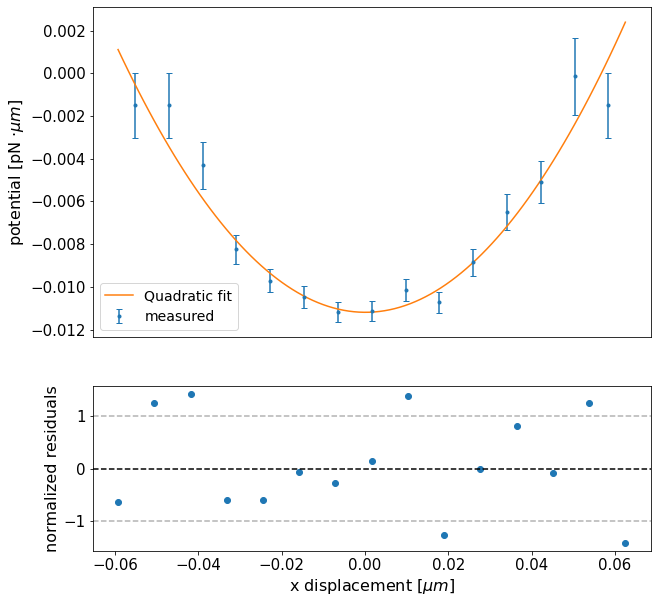

In [75]:
fffilename = 'data/reproducibility/StrongRep4.txt'
data = extract_data(filename)
analysis = gaussian_analysis(data.x_dec, data.y_dec, nbins = 15,temp = T)

def potential_well(x,k,b):
    return 1/2*k*x**2 - b

#change into potential
well_dat = -np.log(analysis.hist_x)*T*k_b*10**18
sigma = 1/analysis.hist_x*T*k_b*10**18*analysis.sigma_x


pOpt, pCov = curve_fit(potential_well, analysis.bins_x, well_dat, p0 = [0.1, np.min(well_dat)], sigma = sigma, absolute_sigma=True)

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,10), gridspec_kw = {'height_ratios': (2,1)})
dx = np.linspace(min(data.x_dec),max(data.x_dec),100)
dy = potential_well(dx, *pOpt)

ax1.errorbar(analysis.bins_x, well_dat, fmt = '.', yerr = sigma, capsize=3, label = 'measured')
ax1.plot(dx, dy, label = 'Quadratic fit')


ax1.legend(fontsize = 14)



norm_res = (well_dat - potential_well(analysis.bins_x, *pOpt))/sigma
ax2.plot(analysis.bins_x, norm_res, 'o')
ax2.axhline(y = 0, color = 'k', linestyle = '--')
ax2.axhline(y = 1, color = 'k', linestyle = '--', alpha = 0.3)
ax2.axhline(y = -1, color = 'k', linestyle = '--', alpha = 0.3)


ax1.set_xticks([], [])
ax1.set_ylabel('potential [pN $\cdot \mu m$]', fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('normalized residuals', fontsize = 16)
ax2.set_xlabel('x displacement [$\mu m$]', fontsize = 16)

fig.savefig('Notes/potential_well_fit_for_ps2.pdf',dpi = 300)
print(np.sqrt(np.diag(pCov)))
print(f"chisq = {np.sum(norm_res**2)} +/- {np.sqrt(len(well_dat) - 2)}")

# Data Extraction
### For Summary

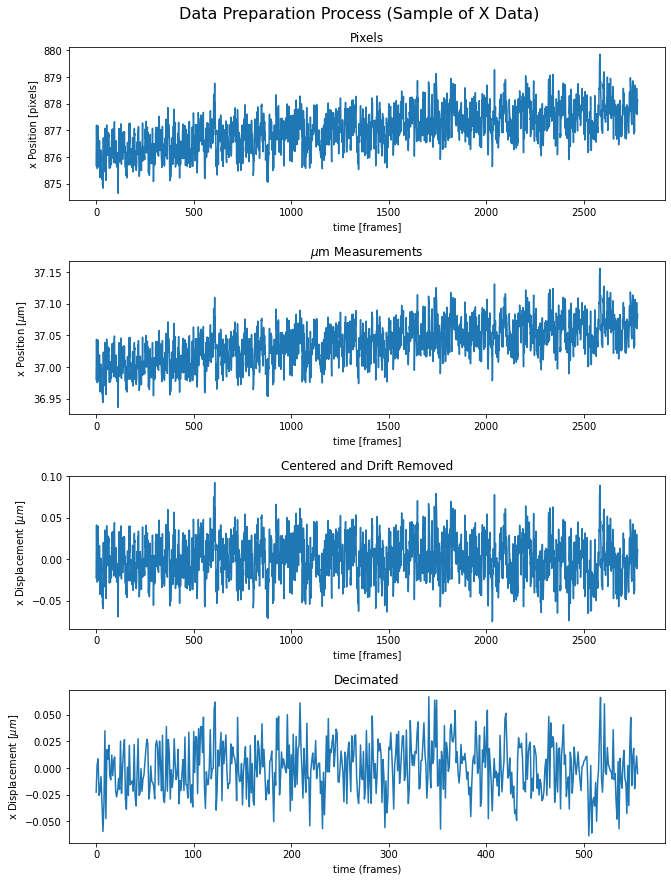

In [16]:
filename = 'data/reproducibility/StrongRep5.txt'

data = extract_data(filename)

fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize = (9,12))
fig.suptitle('Data Preparation Process (Sample of X Data)', fontsize=16,y=1)
fig.tight_layout()

ax1.plot(data.raw_x, label = 'raw')
ax2.plot(data.x_dat, label = 'dat')
ax3.plot(data.x, label = 'clean')
ax4.plot(data.x_dec, label = 'clean')

ax1.set(title = 'Pixels', xlabel = 'time [frames]', ylabel= 'x Position [pixels]')
ax2.set(title = r'$\mu$m Measurements', xlabel = 'time [frames]', ylabel = r'x Position [$\mu$m]')
ax3.set(title = 'Centered and Drift Removed', xlabel = 'time [frames]', ylabel = 'x Displacement [$\mu m$]')
ax4.set(title = 'Decimated', xlabel = 'time (frames)', ylabel = 'x Displacement [$\mu m$]')
plt.subplots_adjust(hspace = 0.4)


#fig.savefig('Notes/data_cleaning_process.pdf', bbox_inches = 'tight',dpi = 300)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb45f9e-f9d7-4771-843d-2a6451217511' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>